# Exam Preparation: Ho-Lee

## Setup

In [2]:
import numpy as np
from scipy.stats import norm, ncx2, gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
import fixed_income_derivatives as fid

## Fitting the Model

We consider the Ho-Lee model in which the short rate has dynamics
$$
d r_t=\Theta(t) d t+\sigma d W_t
$$

**Objective**: fit the model to observed forward rates extracted from the market. 
Assume that we observe the forward rates given in the vector $f^*$.
To estimate $\Theta(t)$ in the Ho-Lee model, we will fit a Nelson-Sigel type function $f(T)$ to the observed prices $f^*$.
$$
f(T)=f_{\infty}+a_0 e^{-b_0 T}+a_1 T e^{-b_1 T}+\ldots=f_{\infty}+a_0 e^{-b_0 T}+\sum_{k=1}^K a_k T^k e^{-b_k T}, \quad b_i>0
$$

How many terms to include in the fit is governed by $K$. We assume a functional form: Nelson-Siegel.
* More K than parameters.
* $f_{\infty}$ governs the long run behavior of the function, as $T$ tends to infinity the two other terms goes to zero. 
* Short term behavior $f_{\infty}+a_0$, where $a$ can be positive or negative. 
* The higher order terms can produce a hump.

### Generate Synthetic Market Data

Firstly, we generate some market data we wish to fit to:

In [5]:
M = 101
T = np.array([0.1*i for i in range(0,M)])

# # Parameters used to generate the data
f_inf_star, a_star, b_star, sigma_star = 0.04, [-0.02,0.01,0.005], [0.5,0.2,0.8], 0.02
param = f_inf_star, a_star, b_star
f_star_data = fid.f_ns(param,T)
#print(f_star_data)

### Plot Spot and Forward Rates

In [89]:
# Initial parameter values
f_inf_0 = (0.03,)
a_0 = -0.05, 0.03, 0.001
b_0 = 0.35, 0.35, 0.7
scaling = 10e12

In [ ]:
K = len(a_0) - 1
param_0 = f_inf_0 + a_0 + b_0

In [90]:
# print(f"Unconstrained optimization")
result = minimize(fit_forward_rate_ns_obj,param_0,method = 'nelder-mead',args = (f_star,T,scaling),options={'xatol': 1e-8,'disp': True})
f_inf_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1:1+K+1], result.x[K+2:K+2+K+1], result.fun
print(f"f_inf_hat: {f_inf_hat}, a_hat: {a_hat}, b_hat: {b_hat}, opt: {result.fun}")
f_fit = fid.f_ns((f_inf_hat,a_hat,b_hat),T)
print(f"r0: {f_fit[0]}")

TypeError: object of type 'int' has no len()

In [ ]:
# Problem 2
def fit_forward_rate_ns_obj(param,f_star,T,scaling):
    K = int((len(param)-1)/2 - 1)
    f_inf, a, b = param[0], param[1:1+K+1], param[K+2:K+2+K+1]
    param_fit = f_inf, a, b
    M = len(T)
    f_fit = fid.f_ns(param_fit,T)
    y = 0
    for m in range(0,M):
        y += scaling*(f_fit[m] - f_star[m])**2
    return y

def fit_forward_rate_ns_jac(param,f_star,T,scaling):
    N = int((len(param)-1)/2 - 1)
    param_fit = param[0], param[1:1+N+1], param[N+2:N+2+N+1]
    M = len(T)
    f_fit = fid.f_ns(param_fit,T)
    jac = np.zeros([len(param)])
    for m in range(0,M):
        # f_deriv = fid.f_ns_jac(param_fit,T[m])
        jac += scaling*2*(f_fit[m] - f_star[m])*fid.f_ns_jac(param_fit,T[m])
    return jac

def fit_forward_rate_ns_hess(param,f_star,T,scaling):
    N = int((len(param)-1)/2 - 1)
    param_fit = param[0], param[1:1+N+1], param[N+2:N+2+N+1]
    M = len(T)
    f_fit = fid.f_ns(param_fit,T)
    hess = np.zeros([len(param),len(param)])
    for m in range(0,M):
        # f_deriv = fid.f_ns_jac(param_fit,T[m])
        f_deriv = fid.f_ns_jac(param_fit,T[m])
        hess += scaling*2*(f_fit[m] - f_star[m])*fid.f_ns_hess(param_fit,T[m]) + 2*np.outer(f_deriv,f_deriv)
    return hess

# Initial parameter values
f_inf_0 = (0.03,)
a_0 = -0.05, 0.03, 0.001
b_0 = 0.35, 0.35, 0.7
scaling = 10e12

K = len(a_0) - 1
param_0 = f_inf_0 + a_0 + b_0
# print(f"Unconstrained optimization")
result = minimize(fit_forward_rate_ns_obj,param_0,method = 'nelder-mead',args = (f_star,T,scaling),options={'xatol': 1e-8,'disp': True})
f_inf_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1:1+K+1], result.x[K+2:K+2+K+1], result.fun
print(f"f_inf_hat: {f_inf_hat}, a_hat: {a_hat}, b_hat: {b_hat}, opt: {result.fun}")
f_fit = fid.f_ns((f_inf_hat,a_hat,b_hat),T)
print(f"r0: {f_fit[0]}")

# # print(f"Optimization using both the Jacobian and the Hessian")
# result = minimize(fit_forward_rate_ns_obj, param_0, method='Newton-CG',args = (f_star,T,scaling),jac = fit_forward_rate_ns_jac, hess=fit_forward_rate_ns_hess,options={'maxiter': 5000, 'xtol': 1e-12, 'disp': False})
# f_inf_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1:1+K+1], result.x[K+2:K+2+K+1], result.fun
# print(f"f_inf_hat: {f_inf_hat}, a_hat: {a_hat}, b_hat: {b_hat}, opt: {result.fun}")
# f_fit = fid.f_ns((f_inf_hat,a_hat,b_hat),T)
# print(f"ro: {f_fit[0]}")

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Empirical and fitted forward rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax.set_ylim([0,0.105])
ax.set_ylabel(f"forward rates",fontsize = 6)
p1 = ax.scatter(T, f_star, s = 1, color = 'black', marker = ".",label="f_star")
p2 = ax.scatter(T, f_fit, s = 1, color = 'red', marker = ".",label="f_fit")

plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

## Price Asian Derivative

**A common practice in finance:**
1) We observe prices in market
2) Fit model to prices
3) Compute something more exotic (not priced in the market) using the fitted model


**Introduction**
We consider an Asian-style derivative which at maturity $S=1$ pays the average short rate over the period from $t=0$ to $S=1$ provided the average short rate is positive. The contract function for this option is in other words
$$
\chi(S)=\frac{1}{S} \max \left(\int_0^S r_u d u, 0\right)=\frac{1}{S}\left(\int_0^S r_u d u\right)_{+}
$$

**How to Compute price of Derivative**:
1) Compute: $\chi_1(S)=\frac{1}{S} \sum_{\mathrm{m}=0}^{\mathrm{M}} r_m$
    - i.e. Simulate the short rate previsouly obtained parameters and $\sigma=0.03$. Denote by $\mathrm{M}$, the number of steps in your simulation. The time points in your simulation will be numbered $m=0,1,2, \ldots, M-1, M$ and the time points will be $\left[t_0, t_1, \ldots, t_{M-1}, t_M\right]=[0, \delta, 2 \delta, \ldots, S-\delta, S]$ and $\delta=\frac{S}{M}$. The scheme you will need to implement is a simple Euler first-order scheme of the form
$$
r_m=r_{m-1}+\Theta\left(t_{m-1}\right) \delta+\sigma \sqrt{\delta} Z_m, \quad m=1,2, \ldots, M
$$
where $Z_m \sim N(0,1), m=1, \ldots, M$ and all the standard normal random variables are independent.
2) This we do for $N$ simulations to get:
$$
\chi_N(S) =\frac{1}{N} \sum_{n=1}^N \chi_n(S)
$$
Notice this Asian type derivative pays the average.

In [85]:
# parameters obtained from earlier
f_inf_hat = 0.0470857723425845
r0 = 0.01946854287371834
a_hat = [-0.02761198, 0.01251315, 0.00146974]
b_hat = [0.38773133, 0.28801503, 0.68312069]
sigma = 0.03
N = 10 # no. of simulations
M, T = 252, 1 # time steps and time to maturity

param = f_inf_hat, a_hat, b_hat, sigma

# Function to compute the price of the Asian derivative
def compute_asian_derivative_price(N, r0, param, M, T):
    chi = 0
    for n in range(0,N):
        r = fid.short_rate_simul(r0, param, M, T, method="ho_lee_ns")
        chi += np.exp(-sum(r)/N) * max(sum(r)/(M+1), 0)
    return chi / N

price = compute_asian_derivative_price(N, r0, param, M, T)
print(f"Price of the Asian derivative: {price:.8f}")

Price of the Asian derivative: 0.01413141


We run the above scheme for increasing values of $N$ and plot the value of the derivative as a function of $N$. Assess how large $N$ has to be for your scheme to have converged and for the price you computed to be reasonably accurate.

In [87]:
# Simulating for increasing values of N and plotting
N_values = np.linspace(10, 10_000, 50, dtype=int) 
asian_derivative_prices = []

for N in N_values:
    price = compute_asian_derivative_price(N, r0, param, M, T)
    asian_derivative_prices.append(price)

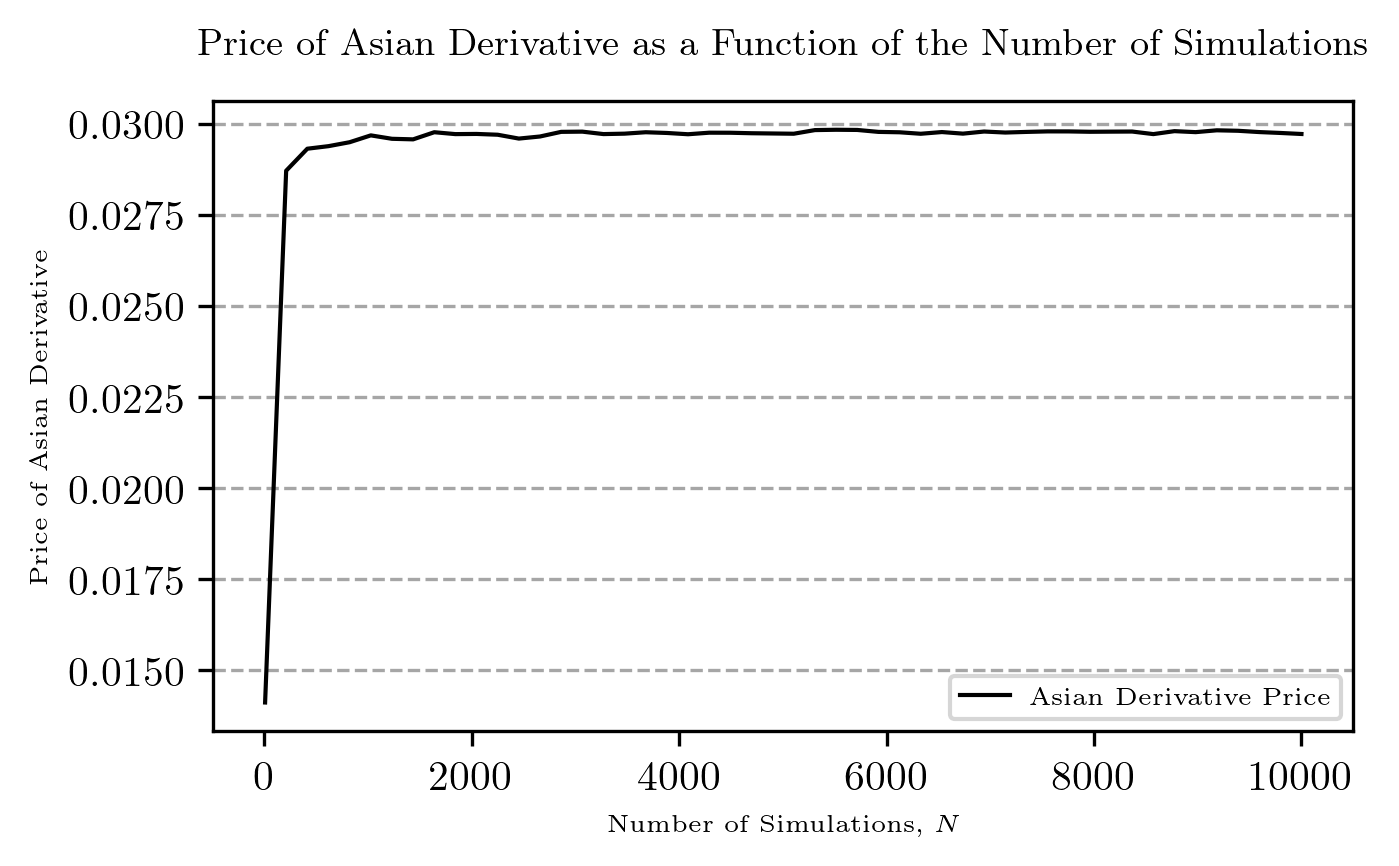

In [107]:
# Creating a plot with the specified style and layout
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5, 3))
fig.suptitle("Price of Asian Derivative as a Function of the Number of Simulations", fontsize=9)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0, 0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

plt.xlabel("Number of Simulations, $N$", fontsize=6)
ax.set_ylabel("Price of Asian Derivative", fontsize=6)

# Plotting the Asian derivative prices
ax.plot(N_values, asian_derivative_prices, color='black', marker='', linewidth=1., label="Asian Derivative Price")

ax.legend(loc="lower right", fontsize=6)
plt.show()

Notice, it converges with rate $\sqrt{n}$ as a function of $N$ (we could explore $N$ and $M$ țade-off).